In [ ]:
# 83 | A모델, B모델

In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from lightgbm import LGBMClassifier

In [7]:
# ✅ 1. 데이터 불러오기
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])

<ipython-input-7-1486842807>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [8]:
# ✅ 2. 공통 피처 생성
df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x)
        for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)

In [9]:
# ✅ 3. HTML 피처 처리
html_features = [col for col in df.columns if col.startswith("html_") and col != 'html_is_shortened']
df[html_features] = df[html_features].fillna(0)
df['url_available'] = df['url_available'].fillna(0).astype(int)
for col in html_features:
    df[col] = df[col] * df['url_available']

In [10]:
# ✅ 4. 파일 확장자 인코딩
if 'file_ext' in df.columns:
    le = LabelEncoder()
    df['file_ext'] = le.fit_transform(df['file_ext'])

In [11]:
# ✅ 5. 피처 목록 구성
base_features = [col for col in df.columns if col not in ['label'] + html_features + ['url_available']]


In [12]:
# ✅ 6. 모델 평가 함수 정의
def evaluate_model(X, y, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LGBMClassifier(
        num_leaves=64,
        max_depth=10,
        learning_rate=0.05,
        n_estimators=500,
        min_child_samples=30,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    conf = confusion_matrix(y_test, y_pred)

    print(f"\n===== 📊 결과: {model_name} =====")
    print("✅ Accuracy:", acc)
    print("📊 Confusion Matrix:\n", conf)
    print("📈 Classification Report:\n", classification_report(y_test, y_pred, digits=4))

    # 혼동행렬 시각화 (함수 안으로 이동)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return acc, f1  # ✅ 함수 안에 있어야 함

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 509554, number of used features: 20
[LightGBM] [Info] Start training from score -0.626529
[LightGBM] [Info] Start training from score -1.802874
[LightGBM] [Info] Start training from score -1.201537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

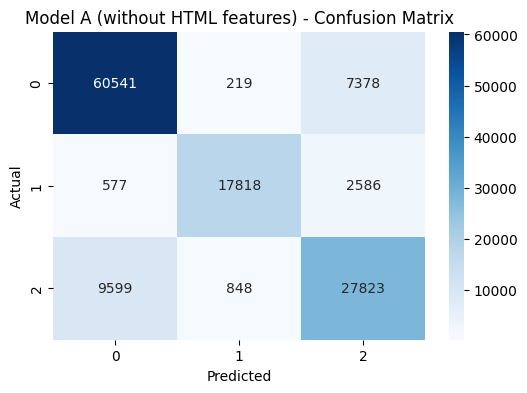

In [16]:
# ✅ 7. A모델 평가 (HTML 제외)
X_a = df[base_features]
y = df['label']
acc_a, f1_a = evaluate_model(X_a, y, "Model A (without HTML features)")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 509554, number of used features: 42
[LightGBM] [Info] Start training from score -0.626529
[LightGBM] [Info] Start training from score -1.802874
[LightGBM] [Info] Start training from score -1.201537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

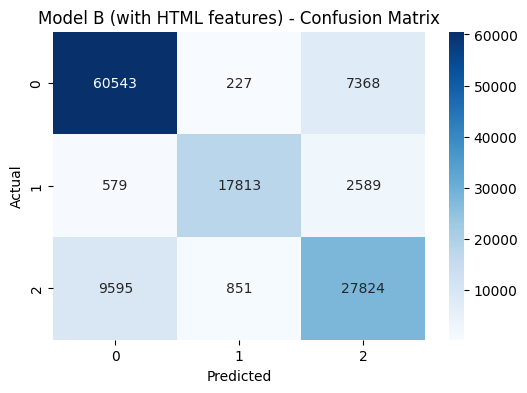

In [17]:
# ✅ 8. B모델 평가 (HTML 포함)
X_b = df[base_features + html_features]
acc_b, f1_b = evaluate_model(X_b, y, "Model B (with HTML features)")

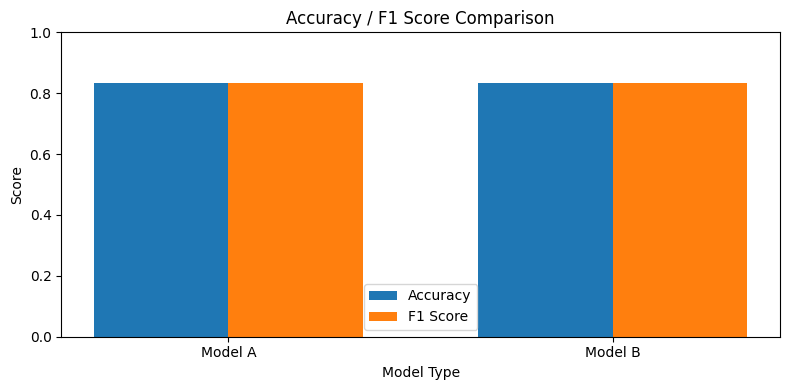

In [18]:
# ✅ 9. Accuracy & F1 Score Comparison Visualization
labels = ['Model A', 'Model B']
accuracy_values = [acc_a, acc_b]
f1_values = [f1_a, f1_b]

plt.figure(figsize=(8, 4))
bar_width = 0.35
index = np.arange(len(labels))

plt.bar(index, accuracy_values, bar_width, label='Accuracy')
plt.bar(index + bar_width, f1_values, bar_width, label='F1 Score')

plt.xlabel('Model Type')
plt.ylabel('Score')
plt.title('Accuracy / F1 Score Comparison')
plt.xticks(index + bar_width / 2, labels)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 89%

In [30]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils import resample
from lightgbm import LGBMClassifier, plot_importance

In [31]:
# ✅ 1. 데이터 로드 및 전처리
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])

df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x)
        for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)

<ipython-input-31-4196564853>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [32]:
# ✅ 2. HTML 피처 처리
html_features = [col for col in df.columns if col.startswith("html_") and col != 'html_is_shortened']
df[html_features] = df[html_features].fillna(0)
df['url_available'] = df['url_available'].fillna(0).astype(int)
df_html = df[df['url_available'] == 1]

In [33]:
# ✅ 3. 피처 리스트 구성
base_features = [col for col in df.columns if col not in html_features + ['label', 'url_available']]
features_all = base_features + html_features

In [34]:
# ✅ 4. 오버샘플링
df_html_upsampled = resample(df_html, replace=True, n_samples=20000, random_state=42)


In [35]:
# ✅ 5. 학습 및 예측
X = df_html_upsampled[features_all]
y = df_html_upsampled['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 45
[LightGBM] [Info] Start training from score -0.640673
[LightGBM] [Info] Start training from score -1.801053
[LightGBM] [Info] Start training from score -1.177858


In [36]:
# ✅ 6. 평가
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred)

print("✅ Accuracy:", acc)
print("✅ F1 Score (macro):", f1_macro)
print("✅ Classification Report:\n", classification_report(y_test, y_pred))
print("✅ Confusion Matrix:\n", conf_matrix)

✅ Accuracy: 0.892
✅ F1 Score (macro): 0.8925826662436577
✅ Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      2081
         1.0       0.96      0.90      0.93       667
         2.0       0.84      0.82      0.83      1252

    accuracy                           0.89      4000
   macro avg       0.90      0.88      0.89      4000
weighted avg       0.89      0.89      0.89      4000

✅ Confusion Matrix:
 [[1942    3  136]
 [   9  602   56]
 [ 208   20 1024]]


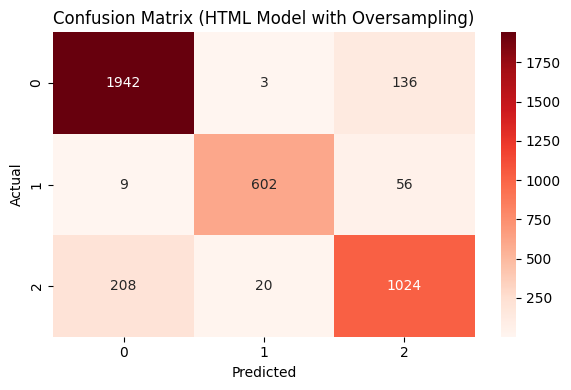

In [42]:
# ✅ 7. 혼동 행렬 시각화 (붉은 계열)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix (HTML Model with Oversampling)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

<ipython-input-40-636767075>:22: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


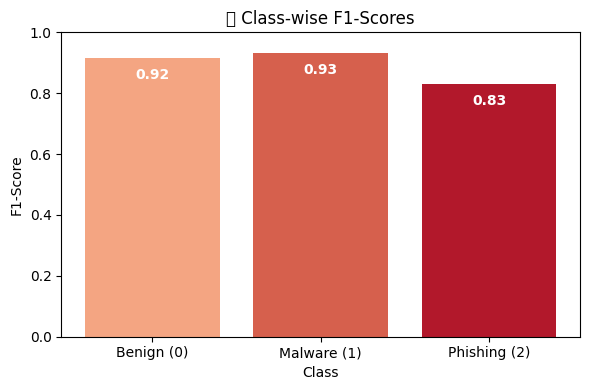

In [40]:
# ✅ 8. 클래스별 F1-score 시각화 (문자열 키로 접근)
report = classification_report(y_test, y_pred, output_dict=True)

# 클래스 키는 문자열 형태로 존재함
f1_scores = [report['0.0']['f1-score'], report['1.0']['f1-score'], report['2.0']['f1-score']]

classes = ['Benign (0)', 'Malware (1)', 'Phishing (2)']
colors = ['#f4a582', '#d6604d', '#b2182b']

plt.figure(figsize=(6, 4))
bars = plt.bar(classes, f1_scores, color=colors)
plt.ylim(0, 1)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('🔍 Class-wise F1-Scores')

# 막대 위에 점수 표기
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, score - 0.08, f'{score:.2f}',
             ha='center', va='bottom', color='white', fontweight='bold')

plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

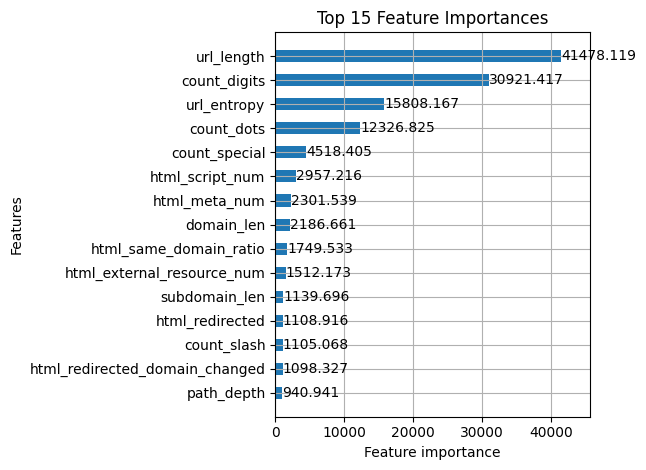

In [41]:
# ✅ 9. 피처 중요도 시각화
plt.figure(figsize=(8, 6))
plot_importance(model, max_num_features=15, importance_type='gain', title="Top 15 Feature Importances", height=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# 메인(기본) 혼동행렬 그림

In [43]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from lightgbm import LGBMClassifier

In [44]:
# ✅ 1. 데이터 불러오기
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])

<ipython-input-44-1486842807>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [45]:
# ✅ 2. 공통 피처 생성
df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x)
        for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)

In [46]:
# ✅ 3. HTML 피처 추출 + 결측값 처리
html_features = [col for col in df.columns if col.startswith("html_") and col != 'html_is_shortened']
df[html_features] = df[html_features].fillna(0)

In [47]:
# ✅ 4. 데이터 분리
df_base = df[df['url_available'] == 0]  # 기본 모델용
df_html = df[df['url_available'] == 1]  # 보조 모델용

In [48]:
# ✅ 5. 기본 모델 (URL 기반만)
base_features = [col for col in df.columns if col not in html_features + ['label', 'url_available']]
X_base = df_base[base_features]
y_base = df_base['label']

X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

base_model = LGBMClassifier(random_state=42)
base_model.fit(X_base_train, y_base_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 501016, number of used features: 20
[LightGBM] [Info] Start training from score -0.626398
[LightGBM] [Info] Start training from score -1.800778
[LightGBM] [Info] Start training from score -1.202921


LGBMClassifier(random_state=42)

In [49]:
# ✅ 6. 보조 모델 (HTML + URL 기반)
features_all = base_features + html_features
X_html = df_html[features_all]
y_html = df_html['label']

X_html_train, X_html_test, y_html_train, y_html_test = train_test_split(X_html, y_html, test_size=0.2, random_state=42)

html_model = LGBMClassifier(random_state=42)
html_model.fit(X_html_train, y_html_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 8537, number of used features: 45
[LightGBM] [Info] Start training from score -0.617919
[LightGBM] [Info] Start training from score -1.828140
[LightGBM] [Info] Start training from score -1.203231


LGBMClassifier(random_state=42)

In [50]:
# ✅ 7. 각각 예측 및 평가
print("\n✅ [기본 모델 평가] (HTML 없음)")
y_base_pred = base_model.predict(X_base_test)
print("Accuracy:", accuracy_score(y_base_test, y_base_pred))
print(classification_report(y_base_test, y_base_pred, digits=4))

print("\n✅ [보조 모델 평가] (HTML 있음)")
y_html_pred = html_model.predict(X_html_test)
print("Accuracy:", accuracy_score(y_html_test, y_html_pred))
print(classification_report(y_html_test, y_html_pred, digits=4))


✅ [기본 모델 평가] (HTML 없음)
Accuracy: 0.8272164783840964
              precision    recall  f1-score   support

         0.0     0.8528    0.8841    0.8682     66959
         1.0     0.9355    0.8382    0.8842     20483
         2.0     0.7268    0.7205    0.7236     37813

    accuracy                         0.8272    125255
   macro avg     0.8384    0.8143    0.8253    125255
weighted avg     0.8283    0.8272    0.8272    125255


✅ [보조 모델 평가] (HTML 있음)
Accuracy: 0.8159250585480093
              precision    recall  f1-score   support

         0.0     0.8447    0.8760    0.8601      1105
         1.0     0.9180    0.8083    0.8597       360
         2.0     0.7188    0.7209    0.7198       670

    accuracy                         0.8159      2135
   macro avg     0.8271    0.8017    0.8132      2135
weighted avg     0.8175    0.8159    0.8160      2135



In [54]:
from sklearn.metrics import accuracy_score

# ✅ 기본 모델 예측 결과
y_base_pred = base_model.predict(X_base_test)
y_base_true = y_base_test

# ✅ 보조 모델 예측 결과
y_html_pred = html_model.predict(X_html_test)
y_html_true = y_html_test

# ✅ 전체 테스트 집합 합치기
y_all_true = pd.concat([y_base_true, y_html_true])
y_all_pred = np.concatenate([y_base_pred, y_html_pred])

# ✅ 전체 정확도
overall_accuracy = accuracy_score(y_all_true, y_all_pred)
print(f"\n🎯 전체 정확도 (B+H 모델 조합): {overall_accuracy:.4f}")



🎯 전체 정확도 (B+H 모델 조합): 0.8270


<ipython-input-52-3590029491>:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


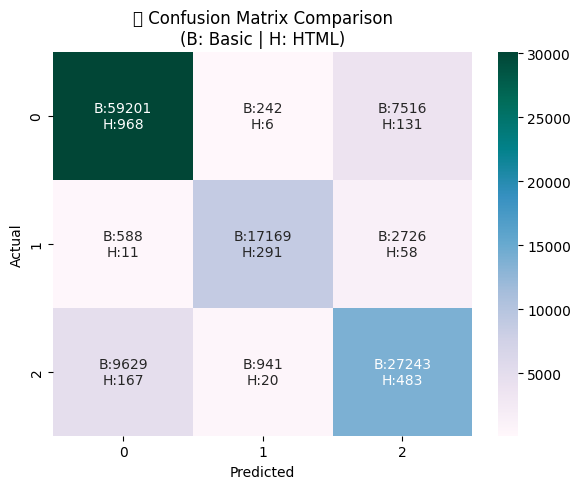

In [52]:
import numpy as np

# ✅ 혼동 행렬
conf_base = confusion_matrix(y_base_test, y_base_pred)
conf_html = confusion_matrix(y_html_test, y_html_pred)

# ✅ 같은 클래스 순서를 가정
combined_text = np.empty_like(conf_base, dtype=object)
for i in range(conf_base.shape[0]):
    for j in range(conf_base.shape[1]):
        combined_text[i, j] = f"B:{conf_base[i, j]}\nH:{conf_html[i, j]}"

# ✅ 단일 heatmap 시각화
plt.figure(figsize=(6, 5))
sns.heatmap((conf_base + conf_html) / 2,  # 색상용 평균값
            annot=combined_text, fmt='', cmap='PuBuGn')
plt.title('📊 Confusion Matrix Comparison\n(B: Basic | H: HTML)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


<ipython-input-53-260180697>:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


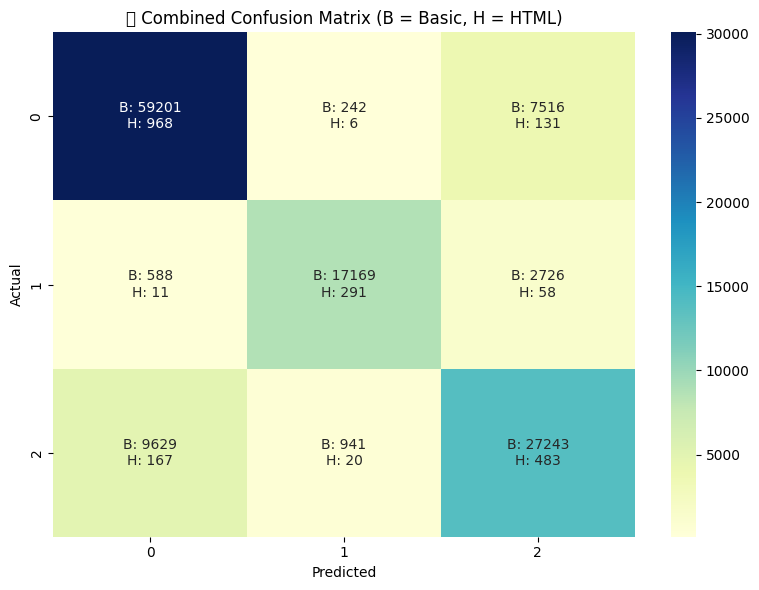

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ✅ B: 기본 모델 혼동 행렬
conf_base = confusion_matrix(y_base_test, y_base_pred)
# ✅ H: 보조 모델 혼동 행렬
conf_html = confusion_matrix(y_html_test, y_html_pred)

# ✅ 텍스트로 병기
combined_text = np.empty_like(conf_base, dtype=object)
for i in range(conf_base.shape[0]):
    for j in range(conf_base.shape[1]):
        combined_text[i, j] = f"B: {conf_base[i, j]}\nH: {conf_html[i, j]}"

# ✅ 평균값으로 색상 intensity 설정
avg_matrix = (conf_base + conf_html) / 2

# ✅ 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(avg_matrix, annot=combined_text, fmt='', cmap='YlGnBu')
plt.title("📊 Combined Confusion Matrix (B = Basic, H = HTML)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
# 89% 보조+메인

In [55]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

In [56]:
# ✅ 메인 모델 (오버샘플링된 HTML 데이터)
X_main = df_html_upsampled[features_all]
y_main = df_html_upsampled['label']
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X_main, y_main, test_size=0.2, random_state=42)

main_model = LGBMClassifier(random_state=42)
main_model.fit(X_train_main, y_train_main)
y_pred_main = main_model.predict(X_test_main)

report_main = classification_report(y_test_main, y_pred_main, output_dict=True)
f1_main = [report_main['0.0']['f1-score'], report_main['1.0']['f1-score'], report_main['2.0']['f1-score']]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 45
[LightGBM] [Info] Start training from score -0.640673
[LightGBM] [Info] Start training from score -1.801053
[LightGBM] [Info] Start training from score -1.177858


In [57]:
# ✅ 보조 모델 (오버샘플링 없이 현실 분포 그대로)
X_sub = df_html[features_all]
y_sub = df_html['label']
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)

sub_model = LGBMClassifier(random_state=42)
sub_model.fit(X_train_sub, y_train_sub)
y_pred_sub = sub_model.predict(X_test_sub)

report_sub = classification_report(y_test_sub, y_pred_sub, output_dict=True)
f1_sub = [report_sub['0.0']['f1-score'], report_sub['1.0']['f1-score'], report_sub['2.0']['f1-score']]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 8537, number of used features: 45
[LightGBM] [Info] Start training from score -0.617919
[LightGBM] [Info] Start training from score -1.828140
[LightGBM] [Info] Start training from score -1.203231


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309

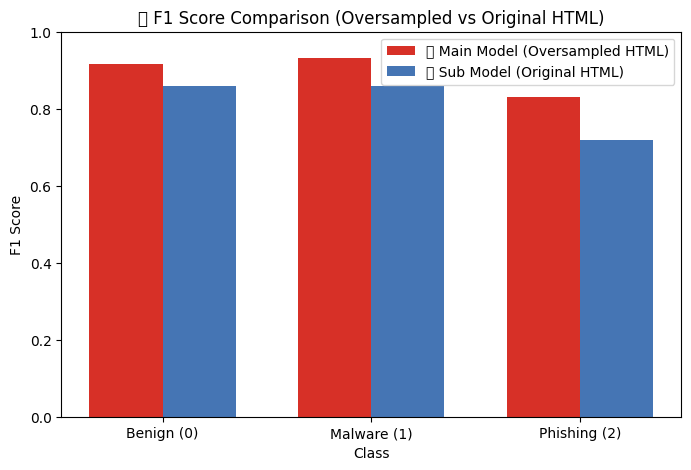

In [58]:
# ✅ 시각화: 합쳐진 F1-score 바차트
labels = ['Benign (0)', 'Malware (1)', 'Phishing (2)']
x = np.arange(len(labels))
bar_width = 0.35

plt.figure(figsize=(8, 5))
bar_main = plt.bar(x - bar_width/2, f1_main, width=bar_width, label='🔴 Main Model (Oversampled HTML)', color='#d73027')
bar_sub = plt.bar(x + bar_width/2, f1_sub, width=bar_width, label='🔵 Sub Model (Original HTML)', color='#4575b4')

plt.xticks(x, labels)
plt.ylim(0, 1)
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('📊 F1 Score Comparison (Oversampled vs Original HTML)')
plt.legend()

<ipython-input-59-419474650>:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


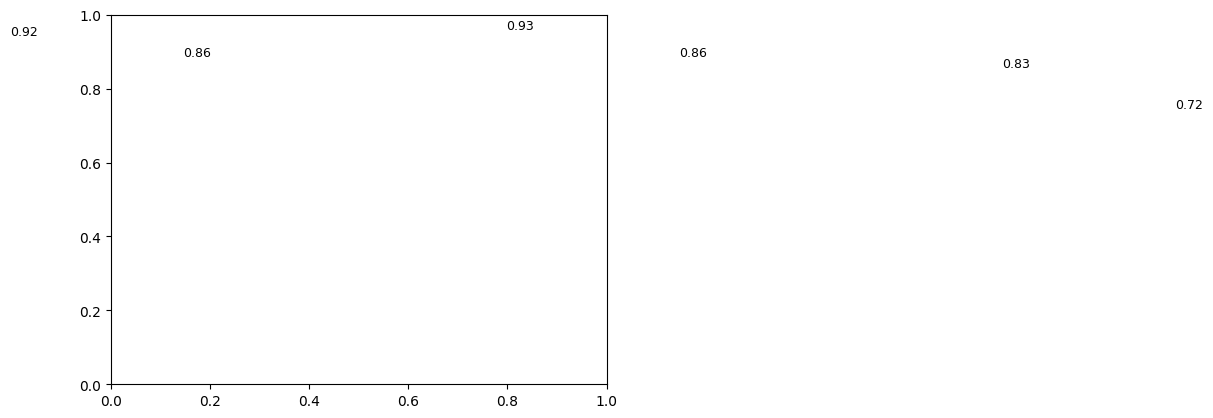

In [59]:
# ✅ 각 막대 위에 점수 출력
for bars in [bar_main, bar_sub]:
    for bar in bars:
        score = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, score + 0.02,
                 f'{score:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

A 모델 f1 score

하이브리드 정확도 83나온거
메인 보조 모델 따로따로 f1 score랑
메인 보조 합친 f1 score

그리고 A 모델은 정확도가 82일떄

최대한 작을때 f1 score

In [63]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample
from lightgbm import LGBMClassifier

In [64]:

# ✅ 1. 데이터 로딩 및 전처리
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])
df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x)
        for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)
html_features = [col for col in df.columns if col.startswith("html_") and col != 'html_is_shortened']
df[html_features] = df[html_features].fillna(0)
df['url_available'] = df['url_available'].fillna(0).astype(int)

base_features = [col for col in df.columns if col not in html_features + ['label', 'url_available']]
features_all = base_features + html_features
y = df['label']

<ipython-input-64-375419231>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [65]:
# ✅ 2. A 모델 (정확도 82% 근처, F1 최소)
acc_min_f1, min_f1 = None, float('inf')
for seed in range(50):
    X_train, X_test, y_train, y_test = train_test_split(df[base_features], y, test_size=0.2, random_state=seed)
    model = LGBMClassifier(random_state=seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    if 0.820 <= acc < 0.830 and f1 < min_f1:
        acc_min_f1, min_f1 = acc, f1

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1178
[LightGBM] [Info] Number of data points in the train set: 509554, number of used features: 20
[LightGBM] [Info] Start training from score -0.626257
[LightGBM] [Info] Start training from score -1.803863
[LightGBM] [Info] Start training from score -1.201478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 509554, number of used features: 20
[LightGBM] [Info] Start training from score -0.626837
[LightGBM] [Info] Start training from score -1.802779
[LightGBM] [Info] Star

In [66]:
# ✅ 3. 메인 모델 (url_available == 0)
df_main = df[df['url_available'] == 0]
X_main = df_main[base_features]
y_main = df_main['label']
X_main_train, X_main_test, y_main_train, y_main_test = train_test_split(X_main, y_main, test_size=0.2, random_state=42)
model_main = LGBMClassifier(random_state=42)
model_main.fit(X_main_train, y_main_train)
f1_main = f1_score(y_main_test, model_main.predict(X_main_test), average='macro')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 501016, number of used features: 20
[LightGBM] [Info] Start training from score -0.626398
[LightGBM] [Info] Start training from score -1.800778
[LightGBM] [Info] Start training from score -1.202921


In [67]:
# ✅ 4. 보조 모델 (url_available == 1 + 오버샘플링)
df_sub = df[df['url_available'] == 1]
df_sub_up = resample(df_sub, replace=True, n_samples=20000, random_state=42)
X_sub = df_sub_up[features_all]
y_sub = df_sub_up['label']
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)
model_sub = LGBMClassifier(random_state=42)
model_sub.fit(X_sub_train, y_sub_train)
f1_sub = f1_score(y_sub_test, model_sub.predict(X_sub_test), average='macro')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 45
[LightGBM] [Info] Start training from score -0.640673
[LightGBM] [Info] Start training from score -1.801053
[LightGBM] [Info] Start training from score -1.177858


In [69]:
# ✅ 5. 하이브리드 모델 (url_available 조건에 따라 예측 분기)
X_all = df[features_all + ['url_available']]
y_all = df['label']
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
mask_html = X_test_all['url_available'] == 1
main_preds = model_main.predict(X_test_all[~mask_html][base_features])
sub_preds = model_sub.predict(X_test_all[mask_html][features_all])

y_combined = pd.concat([y_test_all[~mask_html], y_test_all[mask_html]])
y_pred_combined = np.concatenate([main_preds, sub_preds])
acc_hybrid = accuracy_score(y_combined, y_pred_combined)
f1_hybrid = f1_score(y_combined, y_pred_combined, average='macro')

In [70]:
# ✅ 6. 결과 출력
print(f"✅ A 모델 (정확도 82대) 최소 F1-score: {min_f1:.4f} (Acc: {acc_min_f1:.4f})")
print(f"✅ 메인 모델 F1: {f1_main:.4f}")
print(f"✅ 보조 모델 F1: {f1_sub:.4f}")
print(f"✅ 하이브리드 모델 정확도: {acc_hybrid:.4f} / F1: {f1_hybrid:.4f}")

✅ A 모델 (정확도 82대) 최소 F1-score: 0.8240 (Acc: 0.8251)
✅ 메인 모델 F1: 0.8253
✅ 보조 모델 F1: 0.8926
✅ 하이브리드 모델 정확도: 0.8300 / F1: 0.8276


<ipython-input-73-2086130109>:29: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


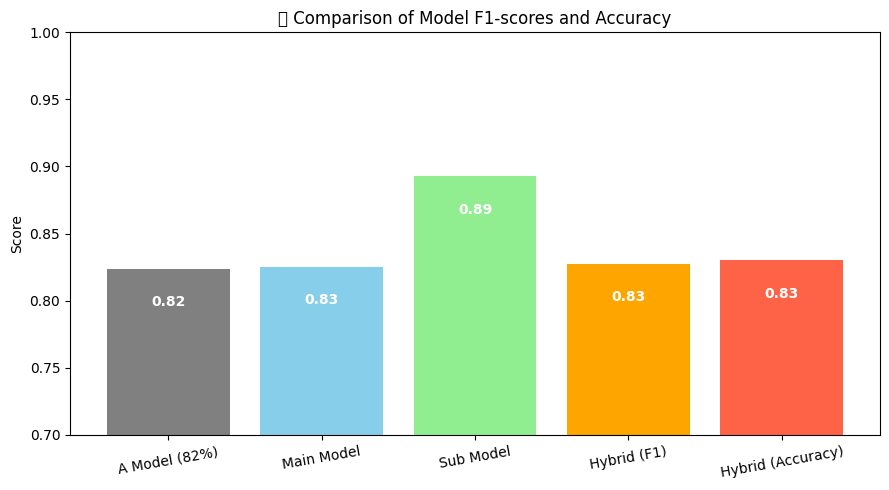

In [73]:
import matplotlib.pyplot as plt

# ✅ Labels & values (영어로)
labels = ['A Model (82%)', 'Main Model', 'Sub Model', 'Hybrid (F1)', 'Hybrid (Accuracy)']
scores = [min_f1, f1_main, f1_sub, f1_hybrid, acc_hybrid]
colors = ['gray', 'skyblue', 'lightgreen', 'orange', 'tomato']

plt.figure(figsize=(9, 5))
bars = plt.bar(labels, scores, color=colors)

plt.ylim(0.7, 1.0)
plt.ylabel('Score')
plt.title('🔍 Comparison of Model F1-scores and Accuracy')

# ✅ 막대 위에 수치 표시 (소수점 2자리, 흰색, bold)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height - 0.03,
        f'{height:.2f}',
        ha='center',
        va='bottom',
        color='white',
        fontweight='bold'
    )

plt.xticks(rotation=10)
plt.tight_layout()
plt.show()


<ipython-input-72-1233409270>:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


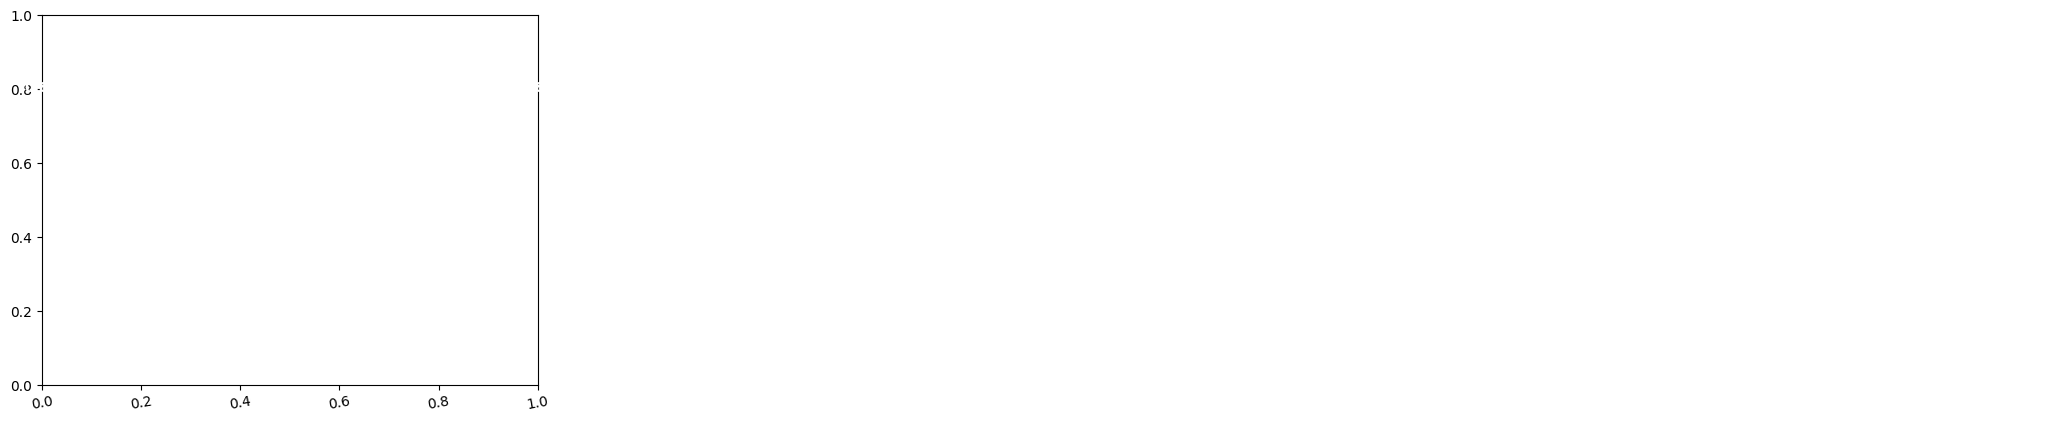

In [72]:
# 막대 위에 수치 표시
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() - 0.04,
             f"{bar.get_height():.2f}",
             ha='center',
             va='bottom',
             color='white',
             fontweight='bold')
plt.tight_layout()
plt.xticks(rotation=10)
plt.show()